In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
def approximate_entropy(x, m, r):
    """
    Implements a vectorized Approximate entropy algorithm.

        https://en.wikipedia.org/wiki/Approximate_entropy

    For short time-series this method is highly dependent on the parameters,
    but should be stable for N > 2000, see:

        Yentes et al. (2012) -
        *The Appropriate Use of Approximate Entropy and Sample Entropy with Short Data Sets*


    Other shortcomings and alternatives discussed in:

        Richman & Moorman (2000) -
        *Physiological time-series analysis using approximate entropy and sample entropy*

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :param m: Length of compared run of data
    :type m: int
    :param r: Filtering level, must be positive
    :type r: float

    :return: Approximate entropy
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)

    N = x.size
    r *= np.std(x)
    if r < 0:
        raise ValueError("Parameter r must be positive.")
    if N <= m + 1:
        return 0

    def _phi(m):
        x_re = np.array([x[i : i + m] for i in range(N - m + 1)])
        C = np.sum(
            np.max(np.abs(x_re[:, np.newaxis] - x_re[np.newaxis, :]), axis=2) <= r,
            axis=0,
        ) / (N - m + 1)
        return np.sum(np.log(C)) / (N - m + 1.0)

    return np.abs(_phi(m) - _phi(m + 1))

## Load and visualize data

데이터 셋에 대하여
88가지 종류의 로봇(id = 1~88)이 실행을 성공했을 때(y = True)와 실패했을 때(y = False) 각 실행 마다 15 개(행)의 힘(F) 및 토크(T) 샘플이 제공되며, 이는 x, y 및 z축에 대해 일정한 시간 간격으로 측정되었다. 따라서 데이터 프레임의 각 행은 특정 실행(id), 시간 인덱스(time)를 가지고 6개 센서(F_x, F_y, F_z, T_x, T_y, T_z)의 각 측정을 포함한다.

** y : 로봇 실행이 성공했냐, 실패했냐. True, False로 구분되며 총 88개의 값

** df(x) :

- id : 실행 횟수(1~88번)
- time : 각 실행당 0~14
- F_x, F_y, F_z, T_x, T_y, T_z : 각 실행했을 때 힘(F) 및 토크(T) 센서 값.

In [3]:
# 데이터 다운로드
from tsfresh.examples import robot_execution_failures

robot_execution_failures.download_robot_execution_failures()
df, y = robot_execution_failures.load_robot_execution_failures()
display(df.head())
print(np.shape(df))

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


(1320, 8)


In [4]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [5]:
print(y.shape)
print(type(y))

(88,)
<class 'pandas.core.series.Series'>


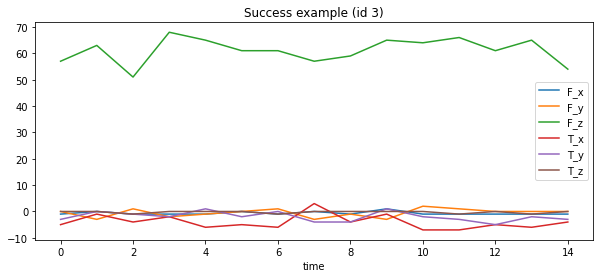

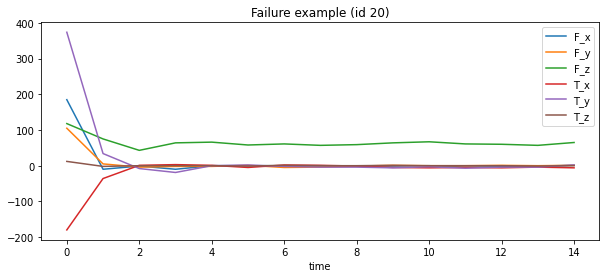

In [6]:
df[df.id == 3][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Success example (id 3)', figsize=(10, 4));
df[df.id == 20][['time', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']].plot(x='time', title='Failure example (id 20)', figsize=(10, 4));

## Extract Features

tsfresh를 사용하여 시계열 데이터의 특징을 추출 할 수 있다. 각 로봇(id)과 측정 된 각 센서 값(F_ * 및 T_ *)에 대한 특징을 추출할 것이다.

같은 id 별로, 그리고 각 센서축(열)별로 특징 값을 추출하게 된다. time 열을 기준으로 시간순으로 정렬해서 추출하게 된다.

추출할 특징 값들은 우선 tsfresh의 default 인 ComprehensiveFCParameters() 를 사용하자. 이 옵션은 tsfresh로 추출할 수 있는 모든 특징을 추출한다.

In [7]:
extraction_settings = ComprehensiveFCParameters()

X = extract_features(df, column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 48/48 [00:05<00:00,  8.40it/s]


In [46]:
X

,T_x__variance_larger_than_standard_deviation,T_x__has_duplicate_max,T_x__has_duplicate_min,T_x__has_duplicate,T_x__sum_values,T_x__abs_energy,T_x__mean_abs_change,T_x__mean_change,T_x__mean_second_derivative_central,T_x__median,...,F_z__permutation_entropy__dimension_5__tau_1,F_z__permutation_entropy__dimension_6__tau_1,F_z__permutation_entropy__dimension_7__tau_1,F_z__query_similarity_count__query_None__threshold_0.0,"F_z__matrix_profile__feature_""min""__threshold_0.98","F_z__matrix_profile__feature_""max""__threshold_0.98","F_z__matrix_profile__feature_""mean""__threshold_0.98","F_z__matrix_profile__feature_""median""__threshold_0.98","F_z__matrix_profile__feature_""25""__threshold_0.98","F_z__matrix_profile__feature_""75""__threshold_0.98"
1,0.0,1.0,1.0,1.0,-43.0,125.0,0.214286,0.071429,0.038462,-3.0,...,1.972247,2.163956,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,-53.0,363.0,3.785714,-0.071429,0.153846,-3.0,...,2.397895,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,-60.0,344.0,3.214286,0.071429,-0.076923,-5.0,...,2.397895,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,-93.0,763.0,3.714286,-0.428571,-0.192308,-6.0,...,2.271869,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,-105.0,849.0,4.071429,-0.357143,0.000000,-8.0,...,2.271869,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,0.0,0.0,1.0,5083.0,1825597.0,18.857143,15.285714,-0.538462,394.0,...,1.366711,1.609438,1.831020,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,1.0,0.0,0.0,1.0,-511.0,18023.0,2.785714,-1.214286,0.192308,-33.0,...,1.972247,2.163956,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,1.0,0.0,0.0,1.0,-987.0,67981.0,3.928571,-3.500000,-0.153846,-65.0,...,0.600166,0.639032,0.683739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,1.0,0.0,0.0,1.0,-1921.0,247081.0,6.642857,-0.357143,0.461538,-126.0,...,1.366711,1.609438,1.831020,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 아래 주석을 해제하면 이 세팅에서 뽑히는 특징값 목록들이 나온다.
extraction_settings

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'root_mean_square': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length':

In [9]:
len(extraction_settings)

74

In [10]:
X.head(5) #보여지는 row를 조절할 수 있다

,T_x__variance_larger_than_standard_deviation,T_x__has_duplicate_max,T_x__has_duplicate_min,T_x__has_duplicate,T_x__sum_values,T_x__abs_energy,T_x__mean_abs_change,T_x__mean_change,T_x__mean_second_derivative_central,T_x__median,...,F_z__permutation_entropy__dimension_5__tau_1,F_z__permutation_entropy__dimension_6__tau_1,F_z__permutation_entropy__dimension_7__tau_1,F_z__query_similarity_count__query_None__threshold_0.0,"F_z__matrix_profile__feature_""min""__threshold_0.98","F_z__matrix_profile__feature_""max""__threshold_0.98","F_z__matrix_profile__feature_""mean""__threshold_0.98","F_z__matrix_profile__feature_""median""__threshold_0.98","F_z__matrix_profile__feature_""25""__threshold_0.98","F_z__matrix_profile__feature_""75""__threshold_0.98"
1,0.0,1.0,1.0,1.0,-43.0,125.0,0.214286,0.071429,0.038462,-3.0,...,1.972247,2.163956,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,-53.0,363.0,3.785714,-0.071429,0.153846,-3.0,...,2.397895,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,-60.0,344.0,3.214286,0.071429,-0.076923,-5.0,...,2.397895,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,-93.0,763.0,3.714286,-0.428571,-0.192308,-6.0,...,2.271869,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,-105.0,849.0,4.071429,-0.357143,0.000000,-8.0,...,2.271869,2.302585,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X.shape # 전체 모습

(88, 4722)

extraction settings 안에 approximate_entropy가 포함되어 있기에 이것만 추출해보겠다.

In [12]:
 extraction_settings = {'approximate_entropy': [{'m': 2, 'r': 0.1},
  {'m': 2, 'r': 0.3},
  {'m': 2, 'r': 0.5},
  {'m': 2, 'r': 0.7},
  {'m': 2, 'r': 0.9}]}

In [13]:
extraction_settings

{'approximate_entropy': [{'m': 2, 'r': 0.1},
  {'m': 2, 'r': 0.3},
  {'m': 2, 'r': 0.5},
  {'m': 2, 'r': 0.7},
  {'m': 2, 'r': 0.9}]}

In [14]:
#extraction_settings = ComprehensiveFCParameters()

X2 = extract_features(df, column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 48/48 [00:00<00:00, 134.93it/s]


In [15]:
X2

,F_x__approximate_entropy__m_2__r_0.1,F_x__approximate_entropy__m_2__r_0.3,F_x__approximate_entropy__m_2__r_0.5,F_x__approximate_entropy__m_2__r_0.7,F_x__approximate_entropy__m_2__r_0.9,F_y__approximate_entropy__m_2__r_0.1,F_y__approximate_entropy__m_2__r_0.3,F_y__approximate_entropy__m_2__r_0.5,F_y__approximate_entropy__m_2__r_0.7,F_y__approximate_entropy__m_2__r_0.9,...,T_y__approximate_entropy__m_2__r_0.1,T_y__approximate_entropy__m_2__r_0.3,T_y__approximate_entropy__m_2__r_0.5,T_y__approximate_entropy__m_2__r_0.7,T_y__approximate_entropy__m_2__r_0.9,T_z__approximate_entropy__m_2__r_0.1,T_z__approximate_entropy__m_2__r_0.3,T_z__approximate_entropy__m_2__r_0.5,T_z__approximate_entropy__m_2__r_0.7,T_z__approximate_entropy__m_2__r_0.9
1,0.026824,0.026824,0.026824,0.026824,0.026824,0.137754,0.137754,0.137754,0.137754,0.137754,...,0.359256,0.359256,0.359256,0.359256,0.359256,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.403633,0.403633,0.403633,0.403633,0.403633,0.024913,0.024913,0.458372,0.458372,0.458372,...,0.024913,0.024913,0.550204,0.550204,0.550204,0.477603,0.477603,0.477603,0.477603,0.477603
3,0.484545,0.484545,0.484545,0.484545,0.484545,0.024913,0.024913,0.024913,0.509242,0.509242,...,0.123934,0.123934,0.123934,0.544536,0.544536,0.445715,0.445715,0.445715,0.445715,0.445715
4,0.222955,0.222955,0.222955,0.222955,0.222955,0.123934,0.123934,0.123934,0.481309,0.481309,...,0.074108,0.074108,0.116317,0.116317,0.492615,0.465279,0.465279,0.465279,0.465279,0.465279
5,0.497167,0.497167,0.497167,0.497167,0.497167,0.074108,0.074108,0.074108,0.495884,0.495884,...,0.123934,0.123934,0.507957,0.507957,0.507957,0.531667,0.531667,0.531667,0.531667,0.531667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.141340,0.226156,0.220128,0.220128,0.214000,0.054671,0.127262,0.225900,0.231029,0.219233,...,0.074108,0.157575,0.044518,0.179144,0.367124,0.074108,0.287774,0.315271,0.200514,0.159534
85,0.074108,0.218477,0.188014,0.167386,0.096872,0.068450,0.068450,0.401496,0.401496,0.332194,...,0.074108,0.223751,0.223751,0.273916,0.166158,0.173160,0.173160,0.194475,0.194475,0.194475
86,0.074108,0.018796,0.006145,0.012191,0.011223,0.074108,0.111077,0.014402,0.013108,0.001455,...,0.074108,0.012760,0.010006,0.006154,0.012235,0.123934,0.153713,0.071505,0.129593,0.023373
87,0.081654,0.041911,0.157758,0.029249,0.020837,0.260330,0.049617,0.053394,0.032126,0.026226,...,0.202406,0.131469,0.018767,0.023974,0.001375,0.024913,0.188753,0.021500,0.012026,0.028666


In [16]:
X2.head(5)

,F_x__approximate_entropy__m_2__r_0.1,F_x__approximate_entropy__m_2__r_0.3,F_x__approximate_entropy__m_2__r_0.5,F_x__approximate_entropy__m_2__r_0.7,F_x__approximate_entropy__m_2__r_0.9,F_y__approximate_entropy__m_2__r_0.1,F_y__approximate_entropy__m_2__r_0.3,F_y__approximate_entropy__m_2__r_0.5,F_y__approximate_entropy__m_2__r_0.7,F_y__approximate_entropy__m_2__r_0.9,...,T_y__approximate_entropy__m_2__r_0.1,T_y__approximate_entropy__m_2__r_0.3,T_y__approximate_entropy__m_2__r_0.5,T_y__approximate_entropy__m_2__r_0.7,T_y__approximate_entropy__m_2__r_0.9,T_z__approximate_entropy__m_2__r_0.1,T_z__approximate_entropy__m_2__r_0.3,T_z__approximate_entropy__m_2__r_0.5,T_z__approximate_entropy__m_2__r_0.7,T_z__approximate_entropy__m_2__r_0.9
1,0.026824,0.026824,0.026824,0.026824,0.026824,0.137754,0.137754,0.137754,0.137754,0.137754,...,0.359256,0.359256,0.359256,0.359256,0.359256,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.403633,0.403633,0.403633,0.403633,0.403633,0.024913,0.024913,0.458372,0.458372,0.458372,...,0.024913,0.024913,0.550204,0.550204,0.550204,0.477603,0.477603,0.477603,0.477603,0.477603
3,0.484545,0.484545,0.484545,0.484545,0.484545,0.024913,0.024913,0.024913,0.509242,0.509242,...,0.123934,0.123934,0.123934,0.544536,0.544536,0.445715,0.445715,0.445715,0.445715,0.445715
4,0.222955,0.222955,0.222955,0.222955,0.222955,0.123934,0.123934,0.123934,0.481309,0.481309,...,0.074108,0.074108,0.116317,0.116317,0.492615,0.465279,0.465279,0.465279,0.465279,0.465279
5,0.497167,0.497167,0.497167,0.497167,0.497167,0.074108,0.074108,0.074108,0.495884,0.495884,...,0.123934,0.123934,0.507957,0.507957,0.507957,0.531667,0.531667,0.531667,0.531667,0.531667


In [17]:
X2.shape

(88, 30)

approximate_entropy의 값들만 뽑은 것이다

총 id가 88개이고 sensor의 갯수는 6개 apporximate_entropy에서 잡은 변수들이 5개이기에 위의 표 형태가 나타난다

## Approximate_entropy

tsfresh로 구한 approximate_entropy값과 raw data를 바로 approximate_entropy의 함수로 돌렸을 때 나온 값을 비교해보자 

In [18]:
X2.head(5)

,F_x__approximate_entropy__m_2__r_0.1,F_x__approximate_entropy__m_2__r_0.3,F_x__approximate_entropy__m_2__r_0.5,F_x__approximate_entropy__m_2__r_0.7,F_x__approximate_entropy__m_2__r_0.9,F_y__approximate_entropy__m_2__r_0.1,F_y__approximate_entropy__m_2__r_0.3,F_y__approximate_entropy__m_2__r_0.5,F_y__approximate_entropy__m_2__r_0.7,F_y__approximate_entropy__m_2__r_0.9,...,T_y__approximate_entropy__m_2__r_0.1,T_y__approximate_entropy__m_2__r_0.3,T_y__approximate_entropy__m_2__r_0.5,T_y__approximate_entropy__m_2__r_0.7,T_y__approximate_entropy__m_2__r_0.9,T_z__approximate_entropy__m_2__r_0.1,T_z__approximate_entropy__m_2__r_0.3,T_z__approximate_entropy__m_2__r_0.5,T_z__approximate_entropy__m_2__r_0.7,T_z__approximate_entropy__m_2__r_0.9
1,0.026824,0.026824,0.026824,0.026824,0.026824,0.137754,0.137754,0.137754,0.137754,0.137754,...,0.359256,0.359256,0.359256,0.359256,0.359256,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.403633,0.403633,0.403633,0.403633,0.403633,0.024913,0.024913,0.458372,0.458372,0.458372,...,0.024913,0.024913,0.550204,0.550204,0.550204,0.477603,0.477603,0.477603,0.477603,0.477603
3,0.484545,0.484545,0.484545,0.484545,0.484545,0.024913,0.024913,0.024913,0.509242,0.509242,...,0.123934,0.123934,0.123934,0.544536,0.544536,0.445715,0.445715,0.445715,0.445715,0.445715
4,0.222955,0.222955,0.222955,0.222955,0.222955,0.123934,0.123934,0.123934,0.481309,0.481309,...,0.074108,0.074108,0.116317,0.116317,0.492615,0.465279,0.465279,0.465279,0.465279,0.465279
5,0.497167,0.497167,0.497167,0.497167,0.497167,0.074108,0.074108,0.074108,0.495884,0.495884,...,0.123934,0.123934,0.507957,0.507957,0.507957,0.531667,0.531667,0.531667,0.531667,0.531667


위에 나온 approximate_entropy에서 id가 1인 것중 첫번째 변수를 가진 값을 확인해보자

In [19]:
df

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [20]:
df2 = df[['id','time','F_x']] #원래 가진 data에서 'id', 'time', 'F_x' 만 뽑아서 df2로 설정

In [21]:
df2 = df2[df2['id'] == 1] #df2에서 다시 'id=1'인 것만 뽑아보려고 한다 (id는 1~88까지 존재)

In [22]:
df2

,id,time,F_x
0,1,0,-1
1,1,1,0
2,1,2,-1
3,1,3,-1
4,1,4,-1
5,1,5,-1
6,1,6,-1
7,1,7,-1
8,1,8,-1
9,1,9,-1


In [23]:
type(df2)

pandas.core.frame.DataFrame

원하는 data를 자른 모습이다

하지만 아래의 approximate_entropy 함수에서 들어갈 data의 형태는 np.array 형태로 들어가야한다. 따라서 현재 Dataframe 형태의 df2를 np.array 형식으로 바꾼다

In [24]:
aa = df2['F_x'].to_list() # 실제로 들어가는 값은 sensor가 인지한 'F_x'값이기에 'F_x' 값만 간추려서 list형으로 만든다

In [25]:
aa = np.array(aa) #np.array로 바꾼다

In [26]:
aa

array([-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [27]:
def approximate_entropy(x, m, r):
    
    if not isinstance(x, (np.ndarray, pd.Series)): # 주어진 인스턴스가 특정 클래스/데이터 타입인지 검사해주는 함수
        x = np.asarray(x) # 입력 데이터를 ndarray로 변환하나 이미 ndarray일 경우에는 새로 메모리에 ndarray가 생성되지는 않는다

    N = x.size 
    r *= np.std(x)
    
    #함수는 지정된 축을 따라 주어진 배열의 표준 편차를 계산
    #왼쪽 변수에 오른쪽 값을 곱하고 그 값은 r에 할당한다
    
    if r < 0:
        raise ValueError("Parameter r must be positive.")
    if N <= m + 1: # N이 m+1 보다 작거나 동일하다면
        return 0

    def _phi(m):
        x_re = np.array([x[i : i + m] for i in range(N - m + 1)])
        C = np.sum(
            np.max(np.abs(x_re[:, np.newaxis] - x_re[np.newaxis, :]), axis=2) <= r,
            axis=0,
        ) / (N - m + 1)
        
        # np.sum = 행렬의 각 요소를 합한다
        # np.max = 최댓값 구한다
        # np.newaxis = 차원을 늘려준다
        return np.sum(np.log(C)) / (N - m + 1.0) 

    return np.abs(_phi(m) - _phi(m + 1))

In [28]:
approximate_entropy(aa,2,0.1) 

# x= aa
# m = 2
# r = 0.1

0.026823705626382588

In [29]:
aa.size

15

In [35]:
np.std(aa)

0.24944382578492946

In [41]:
x = aa
N = x.size
r = np.std(x)
m =2

x_re = np.array([x[i : i + m] for i in range(N - m + 1)])
x_re

array([[-1,  0],
       [ 0, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1]])

In [42]:
C = np.sum(
            np.max(np.abs(x_re[:, np.newaxis] - x_re[np.newaxis, :]), axis=2) <= r,
            axis=0,
        ) / (N - m + 1)
C

array([0.07142857, 0.07142857, 0.85714286, 0.85714286, 0.85714286,
       0.85714286, 0.85714286, 0.85714286, 0.85714286, 0.85714286,
       0.85714286, 0.85714286, 0.85714286, 0.85714286])

In [45]:
x= np.sum(np.log(C)) / (N - m + 1.0)
x

-0.5091373440826868

In [ ]:
#extraction_settings = ComprehensiveFCParameters() 

X3 = extract_features(df2, column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

In [ ]:
X3

같은 값이 나오는 걸 확인 할 수 있다